## Imports

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import hdbscan
from sklearn.metrics import confusion_matrix
from scipy.optimize import linear_sum_assignment
import numpy as np

from methods import *

from river import forest
from protree.data.stream_generators import Sine
from protree.detectors import RaceP
from protree.explainers import APete
from full_window_storage import FullWindowStorage

## Prepare dataset

In [2]:
# Prepare dataset (with duplication for recurrence)
block_size = 1000
ds = Sine(drift_position=[28_000, 52_000, 70_000])

dataset = []
for i in range(100):
    x_block, y_block = zip(*ds.take(block_size))
    dataset.append([x_block, y_block])

dataset = dataset + dataset.copy()  # Duplicate for recurrence

## Run drift detection and windows storage

In [3]:
# Setup detector (unmodified RaceP)
model = forest.ARFClassifier()
detector = RaceP(
    model=model,
    prototype_selector=APete,
    prototype_selector_kwargs={"alpha": 0.01},
    measure="centroid_displacement",
    strategy="total",
    const=3.0
)

# Run detector with full window storage
storage = FullWindowStorage()

print("Running detector with full storage...")
for i in range(len(dataset)):
    x_block, y_block = dataset[i]
    
    # Learn from data
    for x, y in zip(x_block, y_block):
        model.learn_one(x, y)
    
    # Update detector
    detector.update(x_block, y_block)
    
    # Store window data
    current_prototypes = detector.prototypes[1]
    current_explainer = detector.explainers[1]
    
    storage.store_window(
        iteration=i,
        x=x_block,
        y=y_block,
        prototypes=current_prototypes,
        explainer=current_explainer,
        drift=detector.drift_detected
    )
    
    if detector.drift_detected:
        print(f"Iteration {i}: Drift detected!")

print(f"\nStored {len(storage.get_all_iterations())} windows")

# Example 1: Compare two specific windows
print("\n" + "="*70)
print("Example 1: Compare two specific windows")
print("="*70)
distance = storage.compare_two_windows(28, 128, measure="centroid_displacement")
print(f"Distance between window 28 and 128: {distance:.4f}")

distance = storage.compare_two_windows(50, 150, measure="centroid_displacement")
print(f"Distance between window 50 and 150: {distance:.4f}")

# Example 2: Compare one window to all others
print("\n" + "="*70)
print("Example 2: Compare window 28 to all other windows")
print("="*70)
distances = storage.compare_window_to_all(28, measure="centroid_displacement")
print(f"\nTop 10 most similar windows to window 28:")
print(distances.sort_values().head(11))  # Top 11 (includes itself at 0.0)

# Example 3: Access raw data for a window
print("\n" + "="*70)
print("Example 3: Access raw data")
print("="*70)
x, y, prototypes, explainer = storage.get_window_data(28)
print(f"Window 28 data:")
print(f"  Number of samples: {len(x)}")
print(f"  Prototype classes: {list(prototypes.keys())}")
print(f"  Number of prototypes per class: {[len(prototypes[c]) for c in prototypes]}")

# Example 4: Compute full distance matrix
print("\n" + "="*70)
print("Example 4: Compute full distance matrix")
print("="*70)

matrix = storage.compute_distance_matrix(measure="centroid_displacement")
print(f"Matrix shape: {matrix.shape}")
# matrix.to_csv("full_distance_matrix.csv")

Running detector with full storage...
Iteration 27: Drift detected!
Iteration 28: Drift detected!
Iteration 54: Drift detected!
Iteration 55: Drift detected!
Iteration 70: Drift detected!
Iteration 99: Drift detected!
Iteration 100: Drift detected!
Iteration 125: Drift detected!
Iteration 126: Drift detected!
Iteration 157: Drift detected!

Stored 200 windows

Example 1: Compare two specific windows
Distance between window 28 and 128: 0.4038
Distance between window 50 and 150: 0.2322

Example 2: Compare window 28 to all other windows

Top 10 most similar windows to window 28:
28     0.000000
140    0.166204
142    0.171075
34     0.173120
47     0.174854
43     0.178099
132    0.179411
35     0.185926
51     0.187577
38     0.190509
134    0.192290
Name: distance_from_28, dtype: float64

Example 3: Access raw data
Window 28 data:
  Number of samples: 1000
  Prototype classes: [0, 1]
  Number of prototypes per class: [4, 4]

Example 4: Compute full distance matrix
Matrix shape: (200, 20

## Show distance between windows

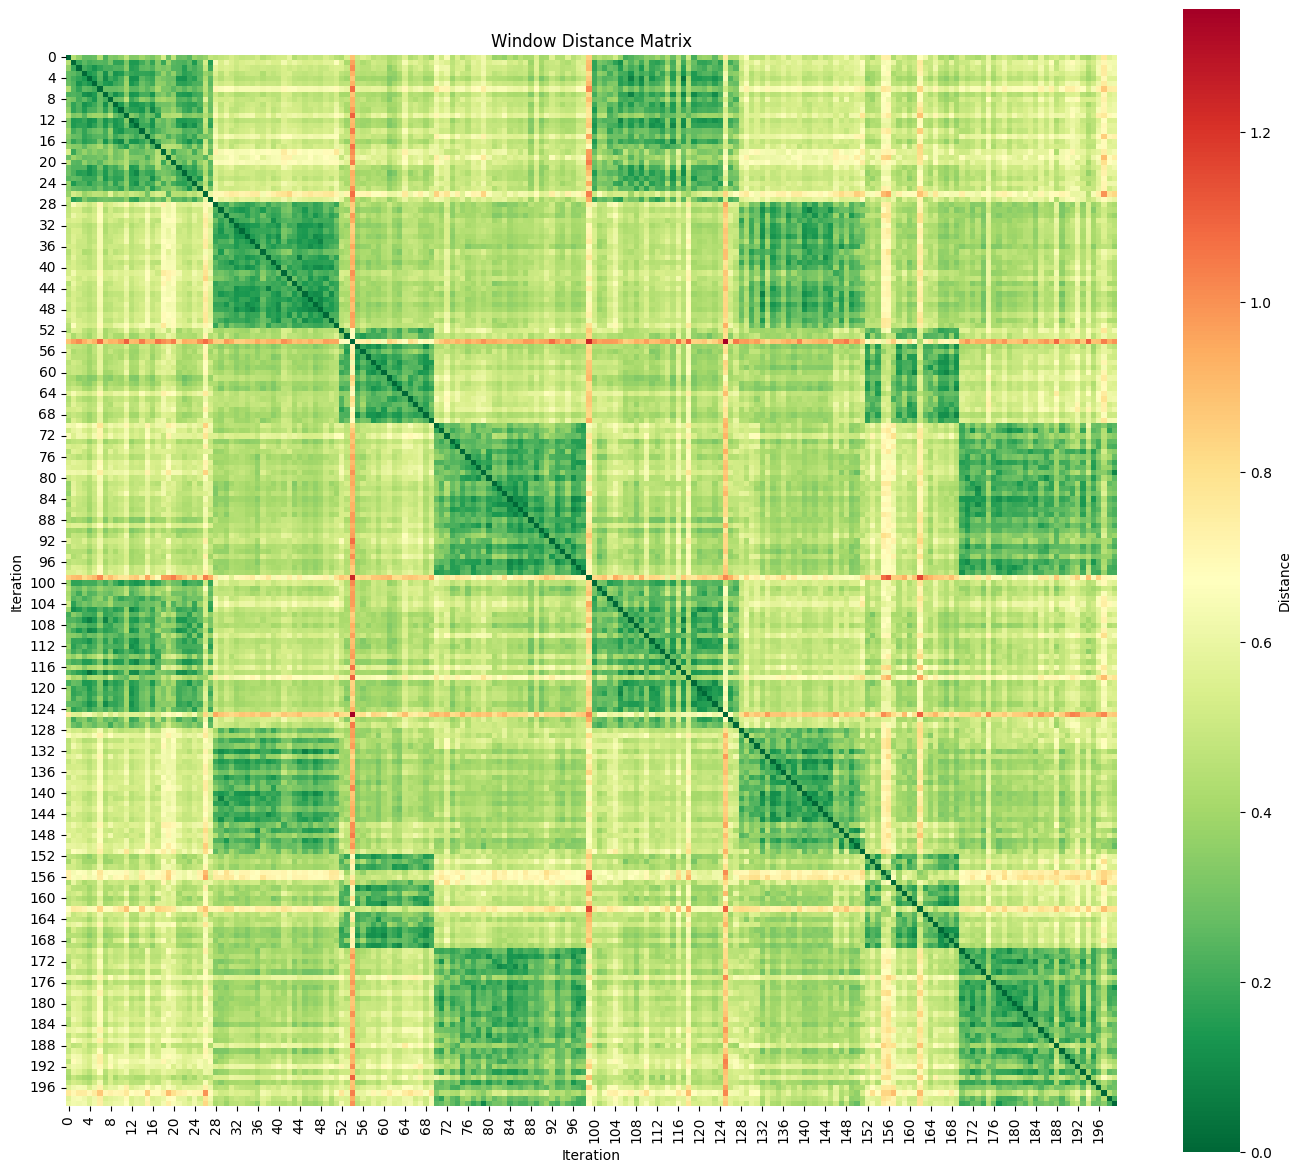

In [4]:
visualize_distance_matrix(matrix)

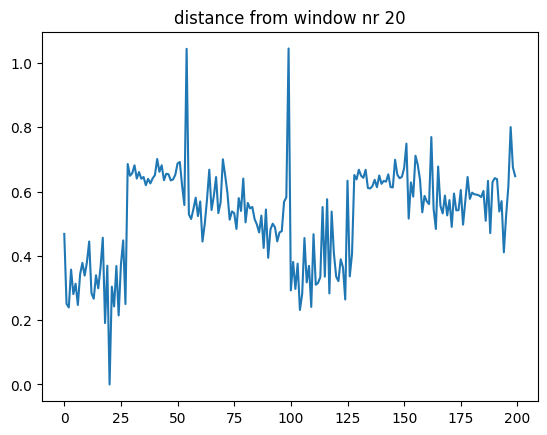

In [5]:
show_distance_median(storage, 20, k=1)

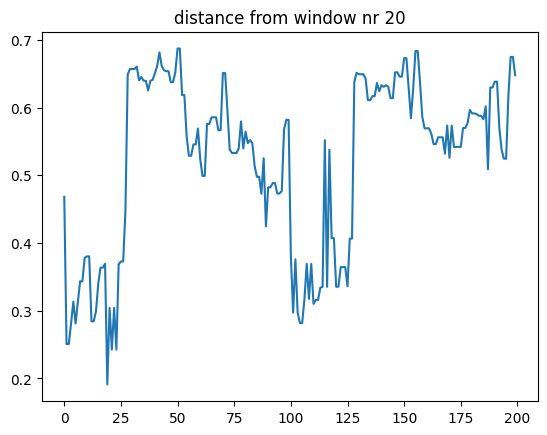

In [6]:
show_distance_median(storage, 20)

## Cluster windows into concepts

We can see which windows are in the same concept even when they are not close to each other temporaly. Also by looking at the place in time when windows change concepts we can accurately detect drifts.

In [7]:
labels = cluster_windows(matrix)
print(labels)

drift_locations = get_drift_from_clusters(labels)
print(drift_locations)

[ 2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2
  2  2  2  2  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  3  3
  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3
  3  3  3 -1  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2
  2  2  2  2  2  2  2  2  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  0  0  0 -1 -1  0  0  0  0  0  0  0  0  0  0  0
  0  0  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3
  3  3  3  3  3  3  3  3]
[28, 52, 70, 100, 128, 152, 170]


## Check accuracy of clustering

In [8]:
# Get true concept labels
def get_region(n):
    if n < 28 or (n >= 100 and n < 128):
        return 0
    if (n >= 28 and n < 52) or (n >= 128 and n < 152):
        return 1
    if (n >= 52 and n < 70) or (n >= 152 and n < 170):
        return 2
    if (n>=70 and n<100) or (n>=170 and n<200):
        return 3
    print(n)
    raise Exception(f"{n} does not correspond to any data distribution")

true_concept_list = np.array([get_region(i) for i in range(len(labels))])

In [9]:
from sklearn.metrics import adjusted_rand_score

adjusted_rand_score(true_concept_list, labels)

0.9827846188499457

In [10]:
from sklearn.metrics import adjusted_mutual_info_score

adjusted_mutual_info_score(true_concept_list, labels)

0.9730173100231887

In [11]:
from sklearn.metrics import fowlkes_mallows_score

fowlkes_mallows_score(true_concept_list, labels)

0.9871911323211217

In [12]:
clustered_labels_accuracy(labels, true_concept_list)

np.float64(0.985)

## Lets check how well the windows are separable into 'different' and 'similar' based on the distance matrix at different threshold levels

Unprocessed:

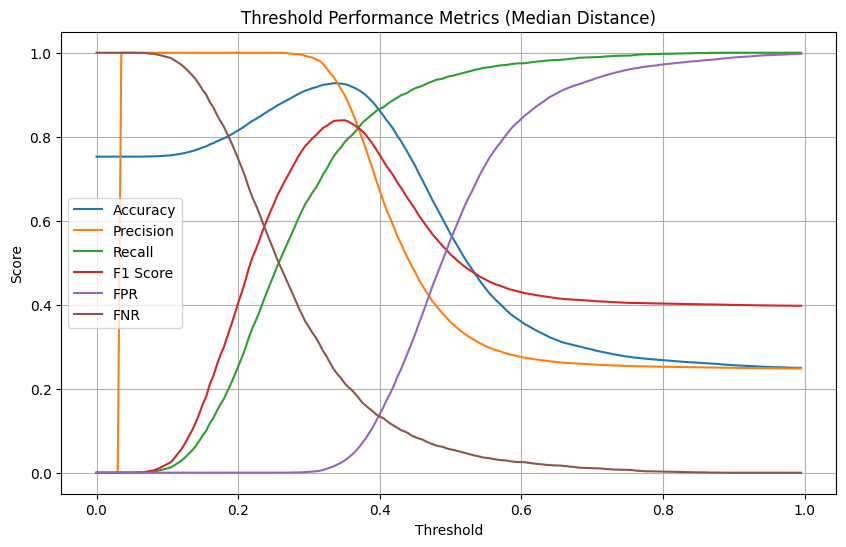

Best Threshold by F1:
{'threshold': 0.35000000000000003, 'accuracy': 0.9255367747830059, 'precision': 0.9003993422598073, 'recall': 0.7860951599671863, 'fpr': 0.028600337268128162, 'fnr': 0.2139048400328138, 'f1': 0.8393736997700646}


In [13]:
plot_threshold_analysis_results(threshold_test(matrix, true_concept_list))

1d median mask of lenght 3 applied to reduce noise:

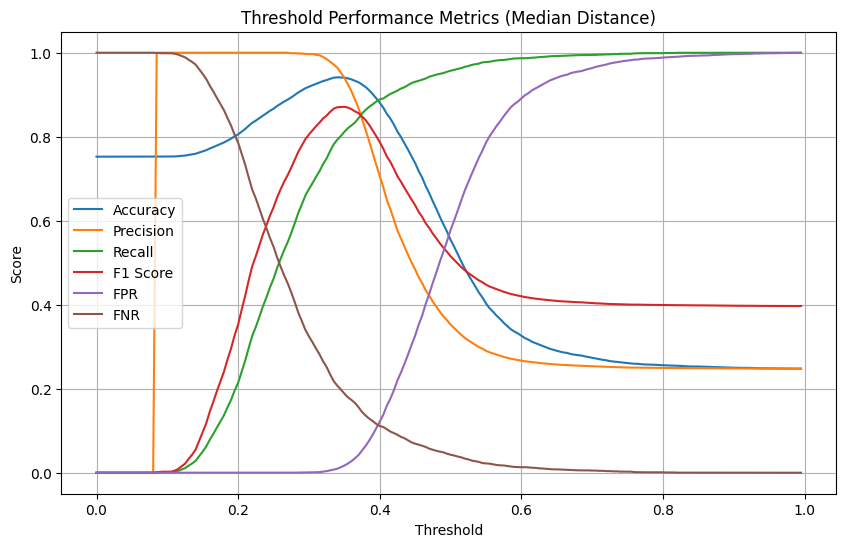

Best Threshold by F1:
{'threshold': 0.35000000000000003, 'accuracy': 0.9406121516674281, 'precision': 0.940351711026616, 'recall': 0.8115258408531584, 'fpr': 0.016930860033726812, 'fnr': 0.18847415914684168, 'f1': 0.8712021136063409}


In [14]:
plot_threshold_analysis_results(threshold_test(matrix, true_concept_list, median_mask_dimensions=(1,3)))